# MSRE CAD - Notebook
The following notebook aims at providing general Openmc modeling capabilities using a pre-generated meshed CAD geometry of the Molten Salt Reactor Experiment (MSRE), operated at ORNL in the 1960s. 

The geometry was designed using `Onshape` cad tool and is free to donwload as a step file from the [msr/msre](https://github.com/openmsr/msre/tree/deplete) repository. 

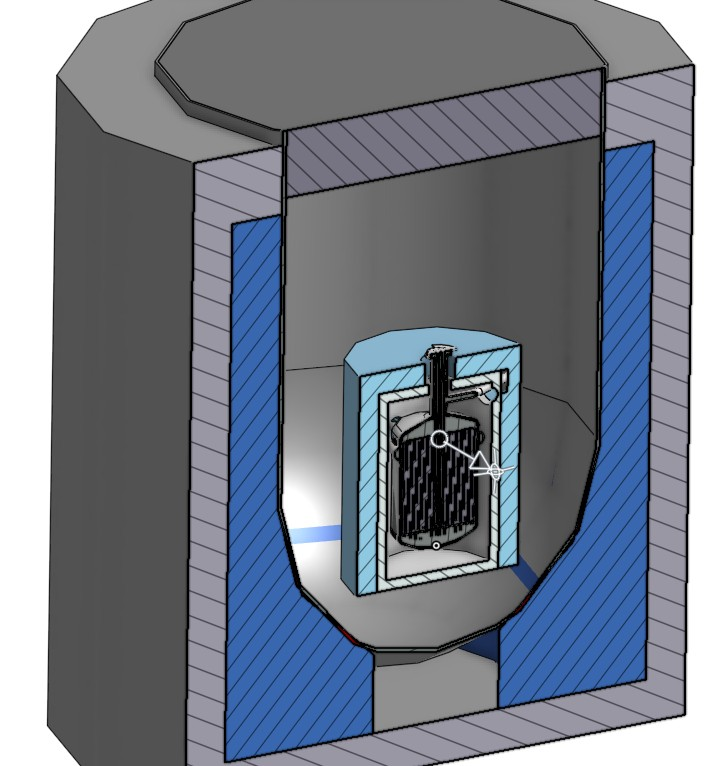

In [62]:
from IPython.display import Image
Image("./images/msre_assembly.jpg", width=400)

Fig. 1: Section view of entire assembly

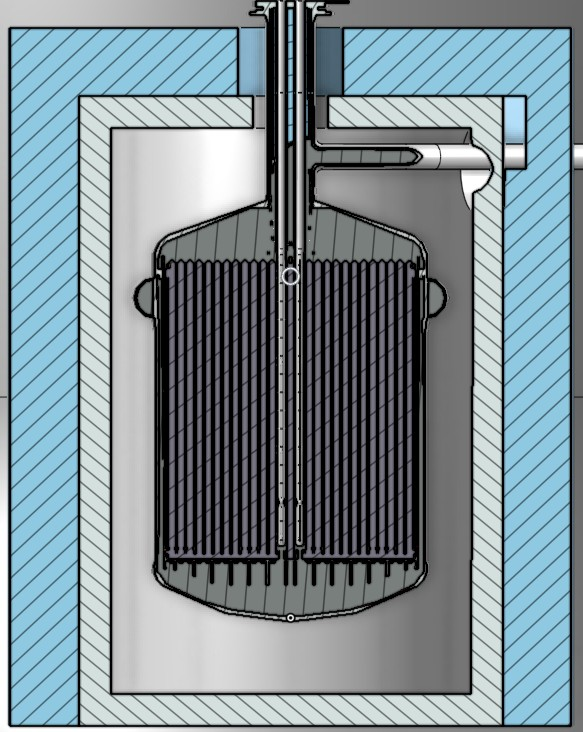

In [63]:
Image("./images/msre_core.jpg", width=400)

Fig. 2: Section view of reactor vessel and thermal shielding

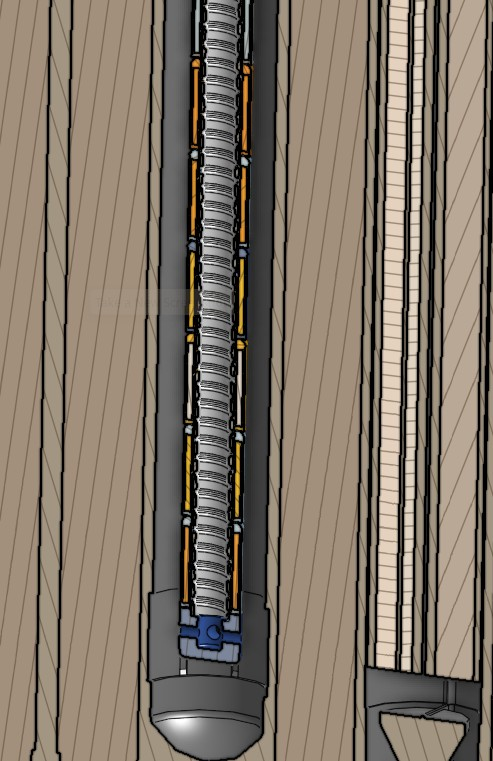

In [64]:
Image("./images/control_rod.jpg", width=400)

Fig. 3: Section view of control rod bottom end

**Note:** Only one control rod is exported from Onshape as a separate step file from the rest of the geometry. 

The h5m surface mesh files were created using `Coreform Cubit`.
The other two control rods are created directly in Openmc, as offset duplicates of the imported one.
The reason to have a separate export of the control rods is to give the user the freedom to position it as needed using Openmc functionailities.



Materials definition are based on ORNL documentation and the [Molten Salt Reactor Experiment
Benchmark Evaluation, Fratoni et. al.](https://www.osti.gov/servlets/purl/1617123) report.

In [13]:
%matplotlib inline

import openmc
import numpy as np
from math import log10
import matplotlib.pyplot as plt
import os 

os.system('rm *.xml *.h5')

0

In this example we will set the fuel salt temperature and density to $638.3 ^\circ C$ and $2.3275 g/cm³$, respectively.

In [6]:
# Define materials 
hot_temp = 638.3 + 273.15 # in K

# Fuel salt 
salt = openmc.Material(name="salt", temperature = hot_temp)
salt.add_nuclide('Li6',1.31480070E-05)
salt.add_nuclide('Li7', 0.262960140146177)
salt.add_nuclide('Be9',1.1863E-01)
salt.add_nuclide('Zr90',1.0543E-02)
salt.add_nuclide('Zr91',2.2991E-03)
salt.add_nuclide('Zr92',3.5142E-03)
salt.add_nuclide('Zr94',3.5613E-03)
salt.add_nuclide('Zr96',5.7375E-04)
salt.add_nuclide('Hf174',8.3786E-10)
salt.add_nuclide('Hf176',2.7545E-08)
salt.add_nuclide('Hf177',9.7401E-08)
salt.add_nuclide('Hf178',1.4285E-07)
salt.add_nuclide('Hf179',7.1323E-08)
salt.add_nuclide('Hf180',1.8370E-07)
salt.add_nuclide('U234',1.034276246E-05)
salt.add_nuclide('U235',1.009695816E-03)
salt.add_nuclide('U236',4.227809892E-06)
salt.add_nuclide('U238',2.168267822E-03)
salt.add_nuclide('Fe54',2.8551E-06)
salt.add_nuclide('Fe56',4.4818E-05)
salt.add_nuclide('Fe57',1.0350E-06)
salt.add_nuclide('Fe58',1.3775E-07)
salt.add_nuclide('Cr50',2.1224E-06)
salt.add_nuclide('Cr52',4.0928E-05)
salt.add_nuclide('Cr53',4.6409E-06)
salt.add_nuclide('Cr54',1.1552E-06)
salt.add_nuclide('Ni58',5.8597E-06)
salt.add_nuclide('Ni60',2.2571E-06)
salt.add_nuclide('Ni61',9.8117E-08)
salt.add_nuclide('Ni62',3.1284E-07)
salt.add_nuclide('Ni64',7.9671E-08)
salt.add_nuclide('O16',5.1437E-04)
salt.add_nuclide('O17',1.8927E-07)
salt.add_nuclide('O18',9.6440E-07)
salt.add_nuclide('F19',5.9409E-01)
salt.set_density('g/cm3', 2.3275)

#Moderator graphite block
graphite = openmc.Material(name='graphite', temperature = hot_temp)
graphite.set_density('g/cm3',1.86)
graphite.add_nuclide('C12',1)
graphite.add_s_alpha_beta('c_Graphite')

#inor-8
inor = openmc.Material(name='inor-8', temperature = hot_temp)
inor.set_density('g/cm3',8.7745)
inor.add_element('Ni',68.5,'wo')
inor.add_element('Mo',16.5,'wo')
inor.add_element('Cr',7,'wo')
inor.add_element('Fe',5,'wo')
inor.add_element('C',0.06,'wo')
inor.add_element('Al',0.25,'wo')
inor.add_element('Ti',0.25,'wo')
inor.add_element('S',0.02,'wo')
inor.add_element('Mn',1.0,'wo')
inor.add_element('Si',1.0,'wo')
inor.add_element('Cu',0.35,'wo')
inor.add_element('B',0.010,'wo')
inor.add_element('W',0.5,'wo')
inor.add_element('P',0.015,'wo')
inor.add_element('Co',0.2,'wo')

#helium
helium = openmc.Material(name='helium')
helium.add_element('He',1.0)
helium.set_density('g/cm3',1.03*(10**-4))

#Control rods inconel clad
trace = 0.01
inconel = openmc.Material(name='inconel', temperature = 65.6 + 273.15)
inconel.add_element('Ni',78.5,percent_type='wo')
inconel.add_element('Cr',14.0,percent_type='wo')
inconel.add_element('Fe',6.5,percent_type='wo')
inconel.add_element('Mn',0.25,percent_type='wo')
inconel.add_element('Si',0.25,percent_type='wo')
inconel.add_element('Cu',0.2,percent_type='wo')
inconel.add_element('Co',0.2,percent_type='wo')
inconel.add_element('Al',0.2,percent_type='wo')
inconel.add_element('Ti',0.2,percent_type='wo')
inconel.add_element('Ta',0.5,percent_type='wo')
inconel.add_element('W',0.5,percent_type='wo')
inconel.add_element('Zn',0.2,percent_type='wo')
inconel.add_element('Zr',0.1,percent_type='wo')
inconel.add_element('C',trace,percent_type='wo')
inconel.add_element('Mo',trace,percent_type='wo')
inconel.add_element('Ag',trace,percent_type='wo')
inconel.add_element('B',trace,percent_type='wo')
inconel.add_element('Ba',trace,percent_type='wo')
inconel.add_element('Be',trace,percent_type='wo')
inconel.add_element('Ca',trace,percent_type='wo')
inconel.add_element('Cd',trace,percent_type='wo')
inconel.add_element('V',trace,percent_type='wo')
inconel.add_element('Sn',trace,percent_type='wo')
inconel.add_element('Mg',trace,percent_type='wo')
inconel.set_density('g/cm3',8.5)

# SS316 control rod flexible hose
ss316 = openmc.Material(name='ss316', temperature = 65.6 + 273.15)
ss316.add_element('C',0.026,'wo')
ss316.add_element('Si',0.37,'wo')
ss316.add_element('Mn',0.16,'wo')
ss316.add_element('Cr',16.55,'wo')
ss316.add_element('Cu',0.16,'wo')
ss316.add_element('Ni',10,'wo')
ss316.add_element('P',0.029,'wo')
ss316.add_element('S',0.027,'wo')
ss316.add_element('Mo',2.02,'wo')
ss316.add_element('N',0.036,'wo')
ss316.add_element('Fe',70.622,'wo')
ss316.set_density('g/cm3',7.99)

#Control rods bushing posion material
Gd2O3 = openmc.Material()
Gd2O3.add_element('Gd',2)
Gd2O3.add_element('O',3)
Gd2O3.set_density('g/cm3',7.41)
Al2O3 = openmc.Material()
Al2O3.add_element('Al',2)
Al2O3.add_element('O',3)
Al2O3.set_density('g/cm3',3.95)
bush = openmc.Material.mix_materials([Gd2O3,Al2O3],[0.7,0.3],'wo')
bush.name='bush'
bush.temperature = 65.6 +273.15

#Concrete block
concrete = openmc.Material(name='concrete')
concrete.add_element('H',0.005,'wo')
concrete.add_element('O',0.496,'wo')
concrete.add_element('Si',0.314,'wo')
concrete.add_element('Ca',0.083,'wo')
concrete.add_element('Na',0.017,'wo')
concrete.add_element('Mn',0.002,'wo')
concrete.add_element('Al',0.046,'wo')
concrete.add_element('S',0.001,'wo')
concrete.add_element('K',0.019,'wo')
concrete.add_element('Fe',0.012,'wo')
concrete.set_density('g/cm3',2.35)

#Thermal shielding as material mix of water and SS304 50-50 vo
water = openmc.Material()
water.add_element('H',2)
water.add_element('O',1)
water.set_density('g/cm3',0.997)

#stainless steel 304
ss304 =  openmc.Material()
ss304.add_element('C',0.08,'wo')
ss304.add_element('Mn',2,'wo')
ss304.add_element('P',0.045,'wo')
ss304.add_element('S',0.03,'wo')
ss304.add_element('Si',0.75,'wo')
ss304.add_element('Cr',19,'wo')
ss304.add_element('Ni',10,'wo')
ss304.add_element('N',0.1,'wo')
ss304.add_element('Fe',67.995, 'wo')
ss304.set_density('g/cm3',7.93)
shield = openmc.Material.mix_materials([water,ss304],[0.5,0.5],'vo')
shield.temperature = 32.2 + 273.15
shield.name='steelwater'

# "Careytemp 1600" by Philip Carey Manufacturing Compamy (Cincinnati) 
insulation=openmc.Material(name='insulation')
insulation.add_element('Si',1)
insulation.add_element('O',2)
insulation.set_density('g/cm3',0.16) 

# Sand water (not sure about this material)
sandwater=openmc.Material(name='sandwater')
sandwater.add_element('Fe',3)
sandwater.add_element('O',4)
sandwater.set_density('g/cm3',6)

#Vessel anular steel
steel = openmc.Material(name='steel')
steel.add_element('Fe',1)
steel.set_density('g/cm3',7.85)

mats = openmc.Materials([salt,graphite,inor,helium,inconel,shield,concrete,steel,ss316,sandwater,insulation,bush])
mats.export_to_xml()

Let's import the h5m mesh files: the full msre reactor and one of the control rods. \
We will create two `Dagmc` universes that will be used to fill the core and control rod cells, respectively. \
As previously anticipated, we will create the other two control rods as conveniently translated replica of the first one. \
All three control rods are now objects and the `translation` attribute value can be set accordinly using the `setattr()` function. 

In this example, we will start by setting all three control rods at the extreme top position (fully withdrawn).

In [7]:
# Import h5m files
core_h5m = '../h5m/msre_reactor_1e-2.h5m'
cr_h5m = '../h5m/msre_control_rod_1e-2.h5m'

# Create DAGMC universes out of h5m files
core = openmc.DAGMCUniverse(filename=core_h5m, auto_geom_ids=True, universe_id=1)
cr = openmc.DAGMCUniverse(filename=cr_h5m, auto_geom_ids=True, universe_id=2)

# Create regions
core_region = core.bounding_region()
cr1_region = cr.bounding_region(boundary_type='transmission', starting_id=20000)

# Extend control rod region, to include upwards translations
cr1_region = cr1_region | cr1_region.translate([0,0,150])

# Create control rod region 2 and 3 as translated region of control rod 1
offset = 10.163255
cr2_region = cr1_region.translate([-offset,0,0])
cr3_region = cr1_region.translate([-offset,offset,0])

# Create openmc Cells 
core_cell = openmc.Cell(region=~(cr1_region | cr2_region | cr3_region) & core_region , fill=core)
cr1_cell = openmc.Cell(name='CR1', region=cr1_region, fill=cr)
cr2_cell = openmc.Cell(name='CR2', region=cr2_region, fill=cr)
cr3_cell = openmc.Cell(name='CR3', region=cr3_region, fill=cr)
    
#translate control rods at top position (fully withdrawn)
inch_to_cm = 2.54
start_pos = 19.2 #cm
top_pos = 51 #inches
setattr(cr1_cell, 'translation', [0, 0, start_pos + top_pos*inch_to_cm])
setattr(cr2_cell, 'translation', [-offset, 0, start_pos + top_pos*2.54])
setattr(cr3_cell, 'translation', [-offset, offset, start_pos + top_pos*2.54])

# Create openmc Geometry object
geometry = openmc.Geometry([core_cell,cr1_cell,cr2_cell,cr3_cell])
geometry.export_to_xml()

Let's initialize some settings and create some generic tallies:

In [8]:
settings = openmc.Settings()
settings.temperature = {'method':'interpolation','range':(293.15,923.15)}
settings.batches = 50
settings.inactive = 20
settings.particles = 30000
settings.photon_transport = False
source_area = openmc.stats.Box([-100., -100., 0.],[ 100.,  100.,  200.],only_fissionable = True)
settings.source = openmc.Source(space=source_area)

In [9]:
tally = dict()
tally['heating'] = openmc.Tally(name="heating")
tally['heating'].scores.append('heating-local')
e_min, e_max = 1e-5, 20e6
groups = 500
energies = np.logspace(log10(e_min), log10(e_max), groups + 1)
energy_filter = openmc.EnergyFilter(energies)
particle_filter = openmc.ParticleFilter(['neutron'])
cell_filter = openmc.MaterialFilter([salt])
tally['flux']= openmc.Tally(name="flux")
tally['flux'].filters = [energy_filter, particle_filter] 
tally['flux'].scores = ['flux']
mesh = openmc.RegularMesh()
mesh.dimension = [500, 500, 1]
mesh.lower_left = [-100, -100, 50]
mesh.upper_right = [100, 100, 200]
mesh_filter = openmc.MeshFilter(mesh)
tally['mesh'] = openmc.Tally(name="Mesh")
tally['mesh'].scores = ['flux','absorption','fission']
tally['mesh'].filters = [mesh_filter]
tally['mesh'].filters.append(particle_filter)
tallies = openmc.Tallies(tally.values())

We can now plot the geometry to see if the control rods are positioned as set:

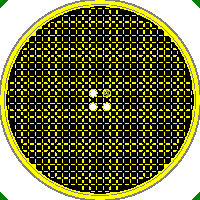

In [10]:
colors = {salt:'yellow', graphite:'black', inor: 'grey', helium: 'cyan', inconel: 'grey', 
              bush: 'blue', ss316: 'grey', concrete: 'brown', shield: 'red', insulation: 'green',
              sandwater: 'lightgreen', steel: 'grey'}
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xy'
plot.width = (150,150)
plot.pixels = (200,200)
plot.origin = (0,0,150)
plot.color_by = 'material'
plot.colors = colors
openmc.plot_inline(plot)

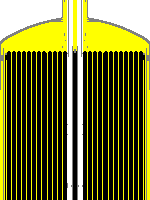

In [45]:
plot.basis = 'xz'
plot.width = (150,200)
plot.pixels = (150,200)
plot.origin = (0,-5,150)
plot.color_by = 'material'
plot.colors = colors
openmc.plot_inline(plot)

In [11]:
model = openmc.model.Model(geometry,mats,settings,tallies)
results=model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Zn64 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn64.h5
 Reading Zn66 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn66.h5
 Reading Zn67 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn67.h5
 Reading Zn68 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn68.h5
 Reading Zn70 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn70.h5
 Reading Ag107 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ag107.h5
 Reading Ag109 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ag109.h5
 Reading Ba130 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba130.h5
 Reading Ba132 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba132.h5
 Reading Ba134 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/lorenzo/Docu

We can now post-process the result file and plot the tallies:

In [12]:
with openmc.StatePoint(results) as sp:
    heating = sp.get_tally(name="heating").get_pandas_dataframe()["mean"].sum()*openmc.data.JOULE_PER_EV
    t = sp.get_tally(name="flux")
    flux = sp.get_tally(name="Mesh").get_slice(scores=['flux']).get_pandas_dataframe()["mean"]
    fission = sp.get_tally(name="Mesh").get_slice(scores=['fission']).get_pandas_dataframe()["mean"]
    absorption = sp.get_tally(name="Mesh").get_slice(scores=['absorption']).get_pandas_dataframe()["mean"]

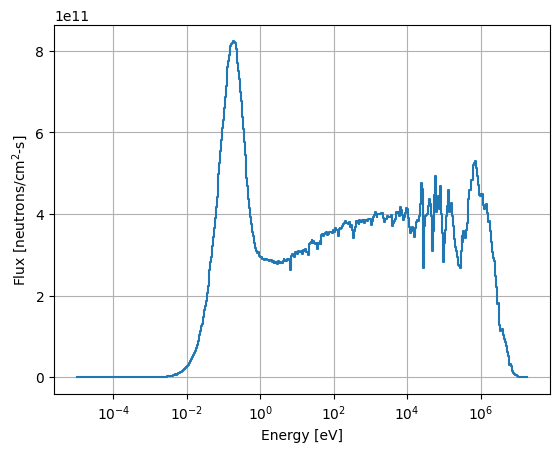

In [35]:
# Plot neutron flux spectrum
power = 8e6 #Thermal power in W
volume = 1.65e6 #Fuel salt volume in cm3

energy_filter = t.filters[0]
energies = energy_filter.bins[:, 0]
mean = t.mean.ravel()
uncertainty = t.get_values(value='std_dev').ravel()
fig, ax = plt.subplots()
ax.plot(energies, mean*power/heating/volume, drawstyle='steps-post')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel(r'Flux [neutrons/cm$^2$-s]')
ax.set_xscale('log')
ax.grid(True, which='both')
plt.show()

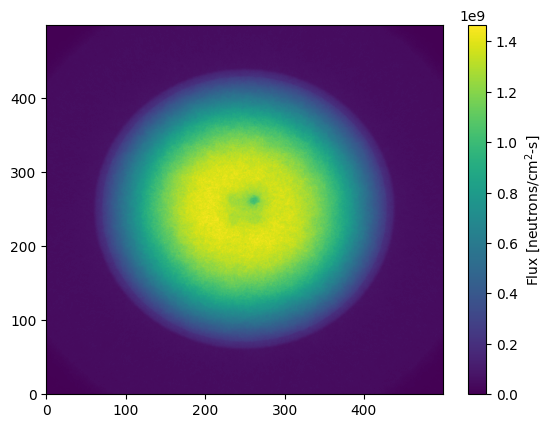

In [36]:

flux = flux.values.reshape(500,500)
fig, ax = plt.subplots()
pos = ax.imshow(flux*power/heating/volume, aspect='auto', origin='lower')
cbar = plt.colorbar(pos,ax=ax,label=r'Flux [neutrons/cm$^2$-s]')
plt.show()

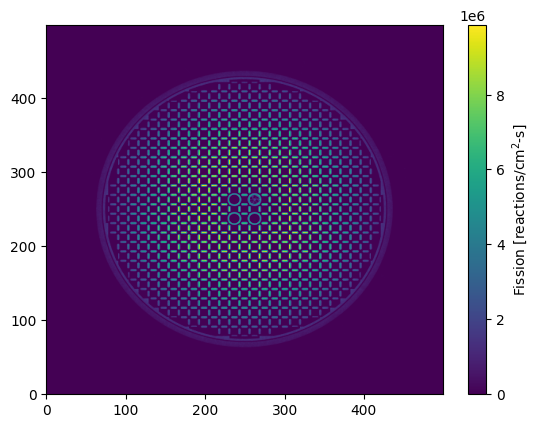

In [37]:

fission = fission.values.reshape(500,500)
fig, ax = plt.subplots()
pos = ax.imshow(fission*power/heating/volume, aspect='auto', origin='lower')
cbar = plt.colorbar(pos,ax=ax,label=r'Fission [reactions/cm$^2$-s]')
plt.show()

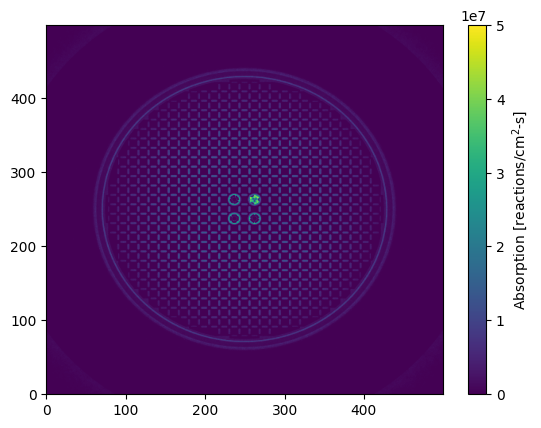

In [38]:

absorption = absorption.values.reshape(500,500)
fig, ax = plt.subplots()
pos = ax.imshow(absorption*power/heating/volume, aspect='auto', origin='lower')
cbar = plt.colorbar(pos,ax=ax,label=r'Absorption [reactions/cm$^2$-s]')
plt.show()

The multiplication factor turns out to be slightly above one, as expected with all control rods fully withdrawn. \

Now, let's see what happens by fully inserting one of the control rods and re-running the simulation:

In [39]:
setattr(cr1_cell, 'translation', [0, 0, start_pos])
results = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Zn64 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn64.h5
 Reading Zn66 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn66.h5
 Reading Zn67 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn67.h5
 Reading Zn68 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn68.h5
 Reading Zn70 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Zn70.h5
 Reading Ag107 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ag107.h5
 Reading Ag109 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ag109.h5
 Reading Ba130 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba130.h5
 Reading Ba132 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba132.h5
 Reading Ba134 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/lorenzo/Docu